In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import torch
from statsmodels.tsa.arima.model import ARIMA

In [2]:
# 读取xlsx文件
data = pd.read_excel('data.xlsx')
yt = data['yt'].values
X = data[['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9']].values

In [3]:
# 划分训练集和测试集
train_size = int(0.7 * len(data))
train_data = data[:train_size]
test_data = data[train_size:]

In [39]:
# 创建 XGBoost 模型并训练
xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=5)
xgb_model.fit(train_data.drop('yt', axis=1), train_data['yt'])


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [40]:
# 预测
y_pred = xgb_model.predict(test_data.drop('yt', axis=1))
mse_xgb = mean_squared_error(test_data['yt'], y_pred)
print(f"XGBoost 均方误差: {mse_xgb}")


XGBoost 均方误差: 10474.390188460424


In [41]:
# 创建时间序列
dates = pd.date_range(start='2009-01', end='2021-9', freq='M')
y = pd.Series(yt[1:], index=dates)

In [42]:
# 拟合 ARIMA 模型
arima_model = ARIMA(y, order=(2, 1, 1))
arima_result = arima_model.fit()

D:\Env\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Env\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [43]:
# ARIMA 预测
forecast = arima_result.get_forecast(steps=len(test_data))
pred = forecast.predicted_mean
ci = forecast.conf_int()

In [44]:
# 计算 ARIMA 预测的均方误差
mse_arima = mean_squared_error(test_data['yt'], pred)
print(f"ARIMA 均方误差: {mse_arima}")

ARIMA 均方误差: 31312.56179444648


In [45]:
# 比较 XGBoost 和 ARIMA 的预测效果
print(f"XGBoost 均方误差: {mse_xgb}")
print(f"ARIMA 均方误差: {mse_arima}")

XGBoost 均方误差: 10474.390188460424
ARIMA 均方误差: 31312.56179444648


In [46]:
# 进行预测
inputs = data.iloc[len(train_data) - 60:, 0].values
inputs = inputs.reshape(-1, 1)
X_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)

arima_predicted = arima_result.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

In [47]:
# XGBoost 预测
xgb_inputs = test_data.drop('yt', axis=1).values
xgb_predicted = xgb_model.predict(xgb_inputs)

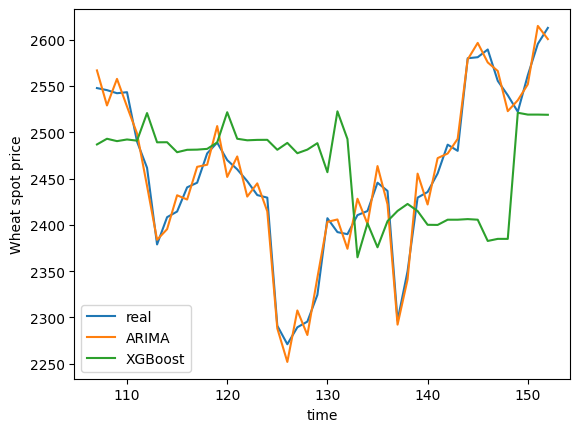

In [48]:
# 可视化预测结果
plt.plot(test_data.index, test_data['yt'], label='real')
plt.plot(test_data.index, arima_predicted, label='ARIMA')
plt.plot(test_data.index, xgb_predicted, label='XGBoost')
plt.xlabel('time')
plt.ylabel('Wheat spot price')
plt.legend()
plt.show()